## Library Import

In [50]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from shapely.geometry import Point
import geopandas as gpd
from geopandas.tools import sjoin
import pyproj
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

from sklearn.inspection import permutation_importance
from matplotlib import rc

### 데이터

In [51]:
bus_path = '../data/bus_feature.csv'
subway_path  = '../data/subway_feature.csv'
dt_bus = pd.read_csv(bus_path)
dt_subway = pd.read_csv(subway_path)

In [52]:
# 기준 금리
base_rate = '../data/base_rate.xlsx'
dt_rate = pd.read_excel(base_rate, header=None)

In [53]:
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [54]:
xy_path  = '../data/xy.csv'
dt_xy = pd.read_csv(xy_path, encoding='cp949')

In [55]:
#train + test
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test]) 
concat['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [56]:
# 시군구와 번지를 기준으로 concat과 dt_xy를 병합
merged_df = pd.merge(concat, dt_xy[['시군구', '번지', 'x', 'y']], how='left', on=['시군구', '번지'])

# 결측치 처리 함수
def handle_missing_values(df):
    # 좌표 X, Y 결측치 처리
    # 좌표 결측치는 평균값으로 대체하는 예시
    imputer = SimpleImputer(strategy='mean')
    df[['좌표X', '좌표Y']] = imputer.fit_transform(df[['좌표X', '좌표Y']])
    
    return df
    
concat = handle_missing_values(concat)

remaining_missing = concat[['좌표X', '좌표Y']].isnull().sum()
print(remaining_missing)

좌표X    0
좌표Y    0
dtype: int64


In [57]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [58]:
# 각 변수별 결측치 개수와 비율 계산
missing_values = concat.isnull().sum()
missing_percentage = (missing_values / len(concat)) * 100

missing_data = pd.DataFrame({
    '변수명': concat.columns,
    '결측치 개수': missing_values,
    '결측치 비율 (%)': missing_percentage
})

# 결측치 비율 내림차순
missing_data = missing_data.sort_values(by='결측치 비율 (%)', ascending=False).reset_index(drop=True)

print(missing_data)

                       변수명   결측치 개수  결측치 비율 (%)
0                 k-135㎡초과  1127765   99.970836
1                  해제사유발생일  1121899   99.450844
2                   k-등록일자  1116386   98.962143
3               단지소개기존clob  1058958   93.871433
4                   k-홈페이지  1013523   89.843843
5                 고용보험관리번호   920757   81.620592
6                 세대전기계약방법   885389   78.485392
7                   k-팩스번호   879348   77.949887
8                    k-시행사   877834   77.815678
9                  청소비관리형태   877751   77.808321
10              k-건설사(시공사)   877637   77.798215
11                 경비비관리형태   877561   77.791478
12      k-단지분류(아파트,주상복합등등)   877273   77.765949
13                  k-전체동수   877207   77.760098
14                   단지승인일   876854   77.728806
15                  k-전화번호   876850   77.728452
16                  k-복도유형   876454   77.693348
17                    건축면적   876279   77.677835
18                    주차대수   876277   77.677658
19           k-사용검사일-사용승인일   876259   77

In [59]:
# 'k-'로 시작하는 열
k_columns = [col for col in concat.columns if col.startswith('k-')]

# '결측치 비율 출력
missing_k_data = missing_data[missing_data['변수명'].isin(k_columns)]
print(missing_k_data)

# 'k-'로 시작하는 열 제거
concat = concat.drop(columns=k_columns)

print(f"제거된 변수: {k_columns}")
print(f"남은 변수 개수: {concat.shape[1]}")
print(concat.head())

                       변수명   결측치 개수  결측치 비율 (%)
0                 k-135㎡초과  1127765   99.970836
2                   k-등록일자  1116386   98.962143
4                   k-홈페이지  1013523   89.843843
7                   k-팩스번호   879348   77.949887
8                    k-시행사   877834   77.815678
10              k-건설사(시공사)   877637   77.798215
12      k-단지분류(아파트,주상복합등등)   877273   77.765949
13                  k-전체동수   877207   77.760098
15                  k-전화번호   876850   77.728452
16                  k-복도유형   876454   77.693348
19           k-사용검사일-사용승인일   876259   77.676062
21  k-전용면적별세대현황(60㎡~85㎡이하)   876170   77.668173
22      k-전용면적별세대현황(60㎡이하)   876170   77.668173
23                  k-수정일자   876170   77.668173
24                k-주거전용면적   876170   77.668173
25            k-85㎡~135㎡이하   876170   77.668173
26                   k-연면적   876125   77.664184
27               k-관리비부과면적   876125   77.664184
30                 k-전체세대수   876125   77.664184
31                  k-난방방식   876125   77

In [60]:
# 필요없는 열 삭제
columns_to_remove = ['등기신청일자', '거래유형', '중개사소재지', 
                    '고용보험관리번호', '경비비관리형태', '세대전기계약방법', 
                     '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', 
                     '관리비 업로드', '단지신청일', '사용허가여부', '건축면적', '해제사유발생일', '단지소개기존clob']

concat= concat.drop(columns=columns_to_remove)

In [61]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '주차대수', '좌표X', '좌표Y', 'target', 'is_test'],
      dtype='object')

In [62]:
# 1. '시군구'에서 '서울특별시'를 제거하고 '구'와 '동'으로 나누기
concat['구'] = concat['시군구'].str.split(' ').str[1]  # '구' 부분 추출
concat['동'] = concat['시군구'].str.split(' ').str[2]  # '동' 부분 추출

# 2. '계약년월'에서 연도 추출 후 건축년도와의 차이를 계산하여 '구매당시 아파트 나이' 열 추가
concat['계약연도'] = concat['계약년월'].astype(str).str[:4].astype(int)  # 계약년월에서 연도만 추출
concat['아파트Age'] = concat['계약연도'] - concat['건축년도']  # 건축년도와의 차이 계산

concat.drop(columns=['시군구', '계약일', '건축년도'], inplace=True)

# 결과 확인
concat.head(10)

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,좌표X,좌표Y,target,is_test,구,동,계약연도,아파트Age
0,658-1,658.0,1.0,개포6차우성,79.97,201712,3,언주로 3,262.0,127.05721,37.476763,124000.0,0,강남구,개포동,2017,30
1,658-1,658.0,1.0,개포6차우성,79.97,201712,4,언주로 3,262.0,127.05721,37.476763,123500.0,0,강남구,개포동,2017,30
2,658-1,658.0,1.0,개포6차우성,54.98,201712,5,언주로 3,262.0,127.05721,37.476763,91500.0,0,강남구,개포동,2017,30
3,658-1,658.0,1.0,개포6차우성,79.97,201801,4,언주로 3,262.0,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
4,658-1,658.0,1.0,개포6차우성,79.97,201801,2,언주로 3,262.0,127.05721,37.476763,117000.0,0,강남구,개포동,2018,31
5,658-1,658.0,1.0,개포6차우성,79.97,201801,1,언주로 3,262.0,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
6,658-1,658.0,1.0,개포6차우성,79.97,201803,2,언주로 3,262.0,127.05721,37.476763,139500.0,0,강남구,개포동,2018,31
7,658-1,658.0,1.0,개포6차우성,54.98,201804,5,언주로 3,262.0,127.05721,37.476763,107500.0,0,강남구,개포동,2018,31
8,658-1,658.0,1.0,개포6차우성,79.97,201806,3,언주로 3,262.0,127.05721,37.476763,145000.0,0,강남구,개포동,2018,31
9,658-1,658.0,1.0,개포6차우성,54.98,201807,3,언주로 3,262.0,127.05721,37.476763,112000.0,0,강남구,개포동,2018,31


In [63]:
#30년 over 됐는지 
concat['30년 건축'] = concat['아파트Age'].apply(lambda x : 1 if x >= 30 else 0)

## 기준금리

In [64]:
#첫 번째 행을 '날짜', 두 번째 행을 '기준금리'로 변환
dt_rate = pd.DataFrame({
    '날짜' : dt_rate.iloc[0, :].values, #세로로 변환
    '기준금리' : dt_rate.iloc[1, :].values
})

dt_rate.reset_index(drop=True, inplace=True)

print(dt_rate.head())

        날짜  기준금리
0  200701월  4.50
1  200702월  4.50
2  200703월  4.50
3  200704월  4.50
4  200705월  4.50


In [65]:
#날짜에서 '월' 지우기
dt_rate['날짜']=dt_rate['날짜'].str.replace('월','')

In [66]:
#데이터타입 일치시키기
dt_rate['날짜'] = dt_rate['날짜'].astype(int)
concat['계약년월'] = concat['계약년월'].astype(int)

# 병합 과정에서 누락되는 것을 방지하기 위해, 계약년월과 기준금리가 일치하는지 직접 확인하는 방식으로 병합
concat['기준금리'] = concat['계약년월'].map(dt_rate.set_index('날짜')['기준금리'])

#날짜 컬럼 제거
#concat.drop(columns='날짜', inplace=True)

#기준금리 데이터타입 변환
concat['기준금리']= concat['기준금리'].astype(float)

#결과 출력
print(concat.head(5))

# 결측치 확인
print(f"기준금리 결측치 수: {concat['기준금리'].isnull().sum()}")

      번지     본번   부번    아파트명   전용면적    계약년월  층    도로명   주차대수        좌표X  \
0  658-1  658.0  1.0  개포6차우성  79.97  201712  3  언주로 3  262.0  127.05721   
1  658-1  658.0  1.0  개포6차우성  79.97  201712  4  언주로 3  262.0  127.05721   
2  658-1  658.0  1.0  개포6차우성  54.98  201712  5  언주로 3  262.0  127.05721   
3  658-1  658.0  1.0  개포6차우성  79.97  201801  4  언주로 3  262.0  127.05721   
4  658-1  658.0  1.0  개포6차우성  79.97  201801  2  언주로 3  262.0  127.05721   

         좌표Y    target  is_test    구    동  계약연도  아파트Age  30년 건축  기준금리  
0  37.476763  124000.0        0  강남구  개포동  2017      30       1   1.5  
1  37.476763  123500.0        0  강남구  개포동  2017      30       1   1.5  
2  37.476763   91500.0        0  강남구  개포동  2017      30       1   1.5  
3  37.476763  130000.0        0  강남구  개포동  2018      31       1   1.5  
4  37.476763  117000.0        0  강남구  개포동  2018      31       1   1.5  
기준금리 결측치 수: 0


In [67]:
concat.isnull().sum()

번지            227
본번             75
부번             75
아파트명         2136
전용면적            0
계약년월            0
층               0
도로명             0
주차대수       876277
좌표X             0
좌표Y             0
target       9272
is_test         0
구               0
동               0
계약연도            0
아파트Age          0
30년 건축          0
기준금리            0
dtype: int64

## 버스, 지하철, 학교 밀집도

In [68]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas.tools import sjoin
import pyproj
from tqdm import tqdm

def preprocess_data(df, x_col, y_col):
    wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 좌표계 (위도, 경도)
    utm_k = pyproj.CRS('EPSG:5179')  # UTM-K 좌표계 (한국)
    project = pyproj.Transformer.from_crs(wgs84, utm_k, always_xy=True).transform
    
    df['geometry'] = df.apply(lambda row: Point(project(row[x_col], row[y_col])), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs=utm_k)

def calculate_density(gdf_real_estate, gdf_locations, radius):
    gdf_real_estate['buffer'] = gdf_real_estate.geometry.buffer(radius)
    
    joined = sjoin(gdf_locations, gdf_real_estate.set_geometry('buffer'), how='inner', predicate='within')
    
    density = joined.groupby(joined.index_right).size().rename('density')
    
    return gdf_real_estate.join(density, how='left').fillna(0)['density']

def process_in_chunks(df, locations_gdf, radius, chunk_size=10000):
    results = []
    for i in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[i:i+chunk_size]
        chunk_gdf = preprocess_data(chunk, '좌표X', '좌표Y')
        density = calculate_density(chunk_gdf, locations_gdf, radius)
        results.append(density)
    return pd.concat(results)

# 버스 정류장과 지하철역 데이터 전처리
bus_gdf = preprocess_data(dt_bus, 'X좌표', 'Y좌표')  # 버스 정류장 좌표계 변환

# 지하철 데이터는 위도, 경도 데이터를 X, Y로 변환
subway_gdf = preprocess_data(dt_subway, '경도', '위도')  # 지하철 데이터도 동일하게 좌표 변환

# 학교 데이터 불러오기 및 전처리
school_path = '../data/school.csv'  # 실제 파일 경로로 변경 필요
df_school = pd.read_csv(school_path)
school_gdf = preprocess_data(df_school, '좌표X', '좌표Y')  # 학교 좌표계 변환

# 반경 설정
bus_radius = 500  # 500m 반경
subway_radius = 1000  # 1km 반경
subway_radius_4km = 4000  # 4km 반경
school_radius = 4000  # 4km 반경

# 청크 크기 설정
chunk_size = 10000

# 버스 정류장 밀도 계산
print("버스 정류장 밀도 계산 중 (500m 반경)...")
concat['bus_stop_density_500m'] = process_in_chunks(concat, bus_gdf, bus_radius, chunk_size)

# 지하철역 밀도 계산 (1km)
print("지하철역 밀도 계산 중 (1km 반경)...")
concat['subway_station_density_1km'] = process_in_chunks(concat, subway_gdf, subway_radius, chunk_size)

# 지하철역 밀도 계산 (4km)
print("지하철역 밀도 계산 중 (4km 반경)...")
concat['subway_station_density_4km'] = process_in_chunks(concat, subway_gdf, subway_radius_4km, chunk_size)

# 학교 밀도 계산 (4km)
print("학교 밀도 계산 중 (4km 반경)...")
concat['school_density_4km'] = process_in_chunks(concat, school_gdf, school_radius, chunk_size)

# 결과 출력
print(concat[['좌표X', '좌표Y', 'bus_stop_density_500m', 'subway_station_density_1km', 'subway_station_density_4km', 'school_density_4km']].head())


버스 정류장 밀도 계산 중 (500m 반경)...


100%|██████████| 113/113 [00:38<00:00,  2.92it/s]


지하철역 밀도 계산 중 (1km 반경)...


100%|██████████| 113/113 [00:35<00:00,  3.20it/s]


지하철역 밀도 계산 중 (4km 반경)...


100%|██████████| 113/113 [01:02<00:00,  1.81it/s]


학교 밀도 계산 중 (4km 반경)...


100%|██████████| 113/113 [01:36<00:00,  1.17it/s]

         좌표X        좌표Y  bus_stop_density_500m  subway_station_density_1km  \
0  127.05721  37.476763                     13                         0.0   
1  127.05721  37.476763                     13                         0.0   
2  127.05721  37.476763                     13                         0.0   
3  127.05721  37.476763                     13                         0.0   
4  127.05721  37.476763                     13                         0.0   

   subway_station_density_4km  school_density_4km  
0                          25                  82  
1                          25                  82  
2                          25                  82  
3                          25                  82  
4                          25                  82  


In [69]:
# '구'의 평균 가격을 기준
gu_order = concat.groupby('구')['target'].mean().sort_values(ascending=False).index.tolist()
gu_mapping = {gu: label for label, gu in enumerate(gu_order)}

# '구'를 평균 가격 순위에 따라 인코딩
concat['new_구'] = concat['구'].map(gu_mapping)

In [70]:
# '동'의 평균 가격을 기준으로 순위를 매김
dong_order = concat.groupby('동')['target'].mean().sort_values(ascending=False).index.tolist()
dong_mapping = {dong: label for label, dong in enumerate(dong_order)}

# '동'을 평균 가격 순위에 따라 인코딩
concat['new_동'] = concat['동'].map(dong_mapping)

In [71]:
# '동'별 target의 표준편차 계산
dong_std_order = concat.groupby('동')['target'].std().sort_values(ascending=False).index.tolist()

# 표준편차를 기준으로 '동'을 순위 매김
dong_std_mapping = {dong: label for label, dong in enumerate(dong_std_order)}

# '동'을 표준편차 순위에 따라 인코딩
concat['동_std'] = concat['동'].map(dong_std_mapping)
print(concat[['동', '동_std']].head())

     동  동_std
0  개포동     27
1  개포동     27
2  개포동     27
3  개포동     27
4  개포동     27


In [72]:
#아파트명 -> cluster

# 'train_test' 열이 없다면 concat이 학습 데이터
train = concat.copy()  
# 'target'의 NaN 값 처리 및 정수변환
train['target'] = train['target'].replace([np.inf, -np.inf], np.nan).fillna(0)
train['target'] = train['target'].astype('int')

#groupby, 아파트 평균 가격 배열 생성
data = train[['아파트명', 'target']].groupby('아파트명').mean()
arr = data['target'].to_numpy().reshape(-1, 1)

# cluster
k = 5  
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(arr)
sort_order = np.argsort(kmeans.cluster_centers_.flatten())

# 군집화 결과를 가격 순서대로 
labels = np.zeros_like(kmeans.labels_)
# 각 클러스터를 가격 순서대로
for i, cluster in enumerate(sort_order):
    labels = np.where(kmeans.labels_ == cluster, i, labels)

# 군집화 결과와 가격을 데이터에 추가
data['cluster'] = labels
data = data.reset_index()
data = data[['아파트명', 'cluster']]

# 원본 데이터프레임에 클러스터 정보 추가 (아파트명 기준 매핑)
concat['아파트명기준_cluster'] = concat['아파트명'].map(data.set_index('아파트명')['cluster'])

print(concat[['아파트명', '아파트명기준_cluster']].head())

     아파트명  아파트명기준_cluster
0  개포6차우성             1.0
1  개포6차우성             1.0
2  개포6차우성             1.0
3  개포6차우성             1.0
4  개포6차우성             1.0


In [73]:
# 최근 3년간 전용면적 대비 거래량
concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')
# 최근 3년 데이터를 필터링.
recent_3_years = concat[concat['계약년월'] >= pd.to_datetime('2021-01-01')]
# 최근 3년간 거래량
transaction_vol = recent_3_years.groupby('아파트명')['target'].count().reset_index()
transaction_vol.columns = ['아파트명', '거래량_최근3년']
# '아파트명'별 거래량 - dict
transaction_vol_dict = transaction_vol.set_index('아파트명')['거래량_최근3년'].to_dict()
# mapping
concat['거래량_최근3년'] = concat['아파트명'].map(transaction_vol_dict)
# '전용면적 대비 거래량 add
concat['전용면적_대비_거래량'] = concat['거래량_최근3년'] / concat['전용면적']
print(concat[['아파트명', '전용면적_대비_거래량']].head(10))

     아파트명  전용면적_대비_거래량
0  개포6차우성     0.087533
1  개포6차우성     0.087533
2  개포6차우성     0.127319
3  개포6차우성     0.087533
4  개포6차우성     0.087533
5  개포6차우성     0.087533
6  개포6차우성     0.087533
7  개포6차우성     0.127319
8  개포6차우성     0.087533
9  개포6차우성     0.127319


In [74]:
#강남역기준 영향
def calculate_distance(lat1, lon1, lat2, lon2):
    # 거리 계산 함수(유클리드)
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

gangnam_center_lat, gangnam_center_lon = 37.4979, 127.0276  # 강남역

concat['강남_거리'] = calculate_distance(concat['좌표Y'], concat['좌표X'], gangnam_center_lat, gangnam_center_lon)

In [75]:
#2019년 이후로 전용면적에 따른 거래건수, 최근가격변동률

concat['계약년월'] = pd.to_datetime(concat['계약년월'], format='%Y%m')
concat['계약년'] = concat['계약년월'].dt.year

# 2019년 이후 데이터 필터링
recent_years = concat[concat['계약년'] >= 2019].copy()

# 전용면적 기준으로 유사한 면적 범위의 데이터 필터링 및 그룹화
recent_years['전용면적_bin'] = (recent_years['전용면적'] // 5) * 5  # 전용면적을 5의 범위로 구분

# 그룹화된 데이터에서 파생변수 계산 (전용면적 ±5 범위를 고려)
recent_years_agg = recent_years.groupby(['new_구', '전용면적_bin']).agg(
    최근_거래건수=('target', 'size'),
    첫번째가격=('target', 'first'),
    마지막가격=('target', 'last')
).reset_index()

# 가격 변동률 계산
recent_years_agg['최근_가격변동률'] = (recent_years_agg['마지막가격'] - recent_years_agg['첫번째가격']) / recent_years_agg['첫번째가격']

# 변동률 계산 후 데이터프레임 확인
print("가격 변동률 계산 후 recent_years_agg 데이터프레임:")
print(recent_years_agg.head())  # 중간 확인용 출력

# concat에서도 동일한 범위로 전용면적을 구분
concat['전용면적_bin'] = (concat['전용면적'] // 5) * 5

# '구'와 '전용면적_bin'을 기준으로 병합을 위한 dictionary 생성
recent_years_agg_dict = recent_years_agg.set_index(['new_구', '전용면적_bin']).to_dict('index')

# 파생변수를 생성할 컬럼을 미리 준비
concat['최근_거래건수'] = concat.apply(lambda x: recent_years_agg_dict.get((x['new_구'], x['전용면적_bin']), {}).get('최근_거래건수', np.nan), axis=1)
concat['최근_가격변동률'] = concat.apply(lambda x: recent_years_agg_dict.get((x['new_구'], x['전용면적_bin']), {}).get('최근_가격변동률', np.nan), axis=1)

# '전용면적_bin' 컬럼 제거
concat = concat.drop(columns=['전용면적_bin'])

# 병합 후 결과 확인 (결측치 개수 확인)
print("after merge: 결측치 개수:")
print(concat[['최근_거래건수', '최근_가격변동률']].isnull().sum())

# 결과 확인
print(concat[['계약년', '전용면적', 'new_구', '최근_거래건수', '최근_가격변동률']].head(10))


가격 변동률 계산 후 recent_years_agg 데이터프레임:
   new_구  전용면적_bin  최근_거래건수    첫번째가격    마지막가격  최근_가격변동률
0      0      10.0       69  14000.0  24000.0  0.714286
1      0      15.0      104  21700.0  32400.0  0.493088
2      0      20.0       62  28000.0  36500.0  0.303571
3      0      25.0      159  34500.0  28000.0 -0.188406
4      0      30.0      644  39800.0  33000.0 -0.170854
after merge: 결측치 개수:
최근_거래건수     219
최근_가격변동률    222
dtype: int64
    계약년   전용면적  new_구  최근_거래건수  최근_가격변동률
0  2017  79.97      0    479.0  0.075377
1  2017  79.97      0    479.0  0.075377
2  2017  54.98      0    263.0 -0.523333
3  2018  79.97      0    479.0  0.075377
4  2018  79.97      0    479.0  0.075377
5  2018  79.97      0    479.0  0.075377
6  2018  79.97      0    479.0  0.075377
7  2018  54.98      0    263.0 -0.523333
8  2018  79.97      0    479.0  0.075377
9  2018  54.98      0    263.0 -0.523333


In [76]:
# 최근_거래건수의 결측치를 0으로 채움
concat['최근_거래건수'].fillna(0, inplace=True)

# 최근_가격변동률의 결측치를 0으로 채움
concat['최근_가격변동률'].fillna(0, inplace=True)

# 결측치 대체 후 결과 확인
print("결측치 대체 후 데이터프레임 확인:")
print(concat[['계약년', '전용면적', '구', '최근_거래건수', '최근_가격변동률']].head(10))

print("결측치 개수 확인:")
print(concat[['최근_거래건수', '최근_가격변동률']].isnull().sum())

결측치 대체 후 데이터프레임 확인:
    계약년   전용면적    구  최근_거래건수  최근_가격변동률
0  2017  79.97  강남구    479.0  0.075377
1  2017  79.97  강남구    479.0  0.075377
2  2017  54.98  강남구    263.0 -0.523333
3  2018  79.97  강남구    479.0  0.075377
4  2018  79.97  강남구    479.0  0.075377
5  2018  79.97  강남구    479.0  0.075377
6  2018  79.97  강남구    479.0  0.075377
7  2018  54.98  강남구    263.0 -0.523333
8  2018  79.97  강남구    479.0  0.075377
9  2018  54.98  강남구    263.0 -0.523333
결측치 개수 확인:
최근_거래건수     0
최근_가격변동률    0
dtype: int64


In [77]:
"""
concat['동_도로명 조합'] = concat['new_동'].astype(str) + '_' + concat['도로명'].astype(str)
concat['동_계약년 조합'] = concat['new_동'].astype(str) + '_' + concat['계약년월'].astype(str)
"""

"\nconcat['동_도로명 조합'] = concat['new_동'].astype(str) + '_' + concat['도로명'].astype(str)\nconcat['동_계약년 조합'] = concat['new_동'].astype(str) + '_' + concat['계약년월'].astype(str)\n"

In [78]:
concat = concat.drop(columns=['좌표X', '좌표Y'])

In [79]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 31 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   번지                          1127867 non-null  object        
 1   본번                          1128019 non-null  float64       
 2   부번                          1128019 non-null  float64       
 3   아파트명                        1125958 non-null  object        
 4   전용면적                        1128094 non-null  float64       
 5   계약년월                        1128094 non-null  datetime64[ns]
 6   층                           1128094 non-null  int64         
 7   도로명                         1128094 non-null  object        
 8   주차대수                        251817 non-null   float64       
 9   target                      1118822 non-null  float64       
 10  is_test                     1128094 non-null  int64         
 11  구                          

In [80]:
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '층', '주차대수', 'target', 'is_test', '계약연도', '아파트Age', '30년 건축', '기준금리', 'bus_stop_density_500m', 'subway_station_density_1km', 'subway_station_density_4km', 'school_density_4km', 'new_구', 'new_동', '동_std', '아파트명기준_cluster', '거래량_최근3년', '전용면적_대비_거래량', '강남_거리', '계약년', '최근_거래건수', '최근_가격변동률']
범주형 변수: ['번지', '아파트명', '계약년월', '도로명', '구', '동']


In [81]:
#categorical - null
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

#continuous - linear
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [82]:
concat.isnull().sum() 

번지                            0
본번                            0
부번                            0
아파트명                          0
전용면적                          0
계약년월                          0
층                             0
도로명                           0
주차대수                          0
target                        0
is_test                       0
구                             0
동                             0
계약연도                          0
아파트Age                        0
30년 건축                        0
기준금리                          0
bus_stop_density_500m         0
subway_station_density_1km    0
subway_station_density_4km    0
school_density_4km            0
new_구                         0
new_동                         0
동_std                         0
아파트명기준_cluster                0
거래량_최근3년                      0
전용면적_대비_거래량                   0
강남_거리                         0
계약년                           0
최근_거래건수                       0
최근_가격변동률                      0
dtype: i

       구        평균 실거래가
0    강남구  114011.706572
1    강동구   54053.477165
2    강북구   38044.077291
3    강서구   44016.379842
4    관악구   41735.543498
5    광진구   66717.460498
6    구로구   38439.281979
7    금천구   33551.694397
8    노원구   33739.071437
9    도봉구   31818.652444
10  동대문구   44895.787936
11   동작구   60516.378080
12   마포구   63914.582161
13  서대문구   48655.021039
14   서초구  112808.452748
15   성동구   68263.246416
16   성북구   44847.382383
17   송파구   83242.901496
18   양천구   58651.847119
19  영등포구   55729.842714
20   용산구  105290.261774
21   은평구   43421.419900
22   종로구   57272.552700
23    중구   61558.171198
24   중랑구   35072.805833


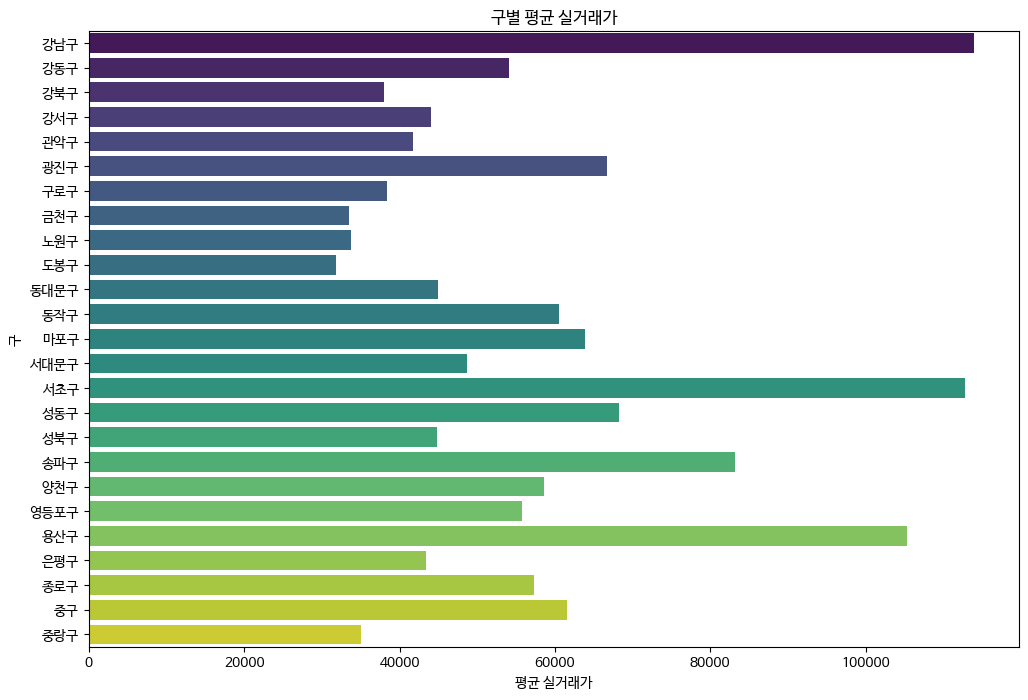

In [83]:
average_price_by_gu = concat.groupby('구')['target'].mean().reset_index()

average_price_by_gu.columns = ['구', '평균 실거래가']

# 결과 출력
print(average_price_by_gu)

plt.figure(figsize=(12, 8))
sns.barplot(data=average_price_by_gu, x='평균 실거래가', y='구', palette='viridis')
plt.title('구별 평균 실거래가')
plt.xlabel('평균 실거래가')
plt.ylabel('구')
plt.show()

In [84]:
#major Gu
all = list(concat['구'].unique())
majorGu = ['용산구','서초구', '강남구', '송파구', '성동구']
notMajorGu = [x for x in all if x not in majorGu]

assert len(all) == len(majorGu) + len(notMajorGu)

In [85]:
is_majorGu = [] 

for x in concat['구'].tolist():
    if x in majorGu:
        is_majorGu.append(1)
    else:
        is_majorGu.append(0)

concat['비싼 구'] = is_majorGu

print(concat[['구', '비싼 구']].head())


     구  비싼 구
0  강남구     1
1  강남구     1
2  강남구     1
3  강남구     1
4  강남구     1


In [86]:
# train과 test dataset을 분할
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# is_test drop
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 31) (9272, 31)


In [87]:
dt_test.head(5)

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,target,...,new_동,동_std,아파트명기준_cluster,거래량_최근3년,전용면적_대비_거래량,강남_거리,계약년,최근_거래건수,최근_가격변동률,비싼 구
0,658-1,658.0,1.0,개포6차우성,79.9700,2023-07-01,5,언주로 3,262.0,13250.0,...,47,27,1.0,7.0,0.087533,0.036380,2023,479.0,0.075377,1
1,651-1,651.0,1.0,개포더샵트리에,108.2017,2023-08-01,10,개포로 311,305.0,13250.0,...,47,27,2.0,1.0,0.009242,0.031596,2023,403.0,-0.125000,1
2,652,652.0,0.0,개포우성3차,161.0000,2023-07-01,15,개포로 307,419.0,13250.0,...,47,27,2.0,11.0,0.068323,0.031657,2023,334.0,-0.060000,1
3,652,652.0,0.0,개포우성3차,133.4600,2023-08-01,14,개포로 307,419.0,13250.0,...,47,27,2.0,11.0,0.082422,0.031657,2023,294.0,-0.512255,1
4,652,652.0,0.0,개포우성3차,104.4300,2023-08-01,6,개포로 307,419.0,13250.0,...,47,27,2.0,11.0,0.105334,0.031657,2023,272.0,0.397802,1


In [88]:
dt_test['target'] = 0

In [89]:
#파생변수들 추가
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['본번', '부번', '전용면적', '층', '주차대수', 'target', '계약연도', '아파트Age', '30년 건축', '기준금리', 'bus_stop_density_500m', 'subway_station_density_1km', 'subway_station_density_4km', 'school_density_4km', 'new_구', 'new_동', '동_std', '아파트명기준_cluster', '거래량_최근3년', '전용면적_대비_거래량', '강남_거리', '계약년', '최근_거래건수', '최근_가격변동률', '비싼 구']
범주형 변수: ['번지', '아파트명', '계약년월', '도로명', '구', '동']


In [90]:
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(dt_train[col].astype(str))
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더를 저장

    # Test 데이터에 대해 Label Encoding 적용
    # 새로운 라벨이 존재할 경우 예외 처리
    dt_test[col] = dt_test[col].astype(str)  # Ensure test data is also string
    unseen_labels = set(dt_test[col].unique()) - set(lbl.classes_)

    if unseen_labels:
        # 새로운 라벨을 인코더에 추가
        lbl.classes_ = np.append(lbl.classes_, list(unseen_labels))

    # Test 데이터 변환
    dt_test[col] = lbl.transform(dt_test[col])

# 결과 출력 확인
print(dt_train.head())
print(dt_test.head())


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

     번지     본번   부번  아파트명   전용면적  계약년월  층   도로명   주차대수    target  ...  new_동  \
0  4732  658.0  1.0   328  79.97   131  3  6176  262.0  124000.0  ...     47   
1  4732  658.0  1.0   328  79.97   131  4  6176  262.0  123500.0  ...     47   
2  4732  658.0  1.0   328  54.98   131  5  6176  262.0   91500.0  ...     47   
3  4732  658.0  1.0   328  79.97   132  4  6176  262.0  130000.0  ...     47   
4  4732  658.0  1.0   328  79.97   132  2  6176  262.0  117000.0  ...     47   

   동_std  아파트명기준_cluster  거래량_최근3년  전용면적_대비_거래량    강남_거리   계약년  최근_거래건수  \
0     27             1.0       7.0     0.087533  0.03638  2017    479.0   
1     27             1.0       7.0     0.087533  0.03638  2017    479.0   
2     27             1.0       7.0     0.127319  0.03638  2017    263.0   
3     27             1.0       7.0     0.087533  0.03638  2018    479.0   
4     27             1.0       7.0     0.087533  0.03638  2018    479.0   

   최근_가격변동률  비싼 구  
0  0.075377     1  
1  0.075377     1  
2 -0.523

In [91]:
dt_train.head(1)  

,번지,본번,부번,아파트명,전용면적,계약년월,층,도로명,주차대수,target,...,new_동,동_std,아파트명기준_cluster,거래량_최근3년,전용면적_대비_거래량,강남_거리,계약년,최근_거래건수,최근_가격변동률,비싼 구
0,4732,658.0,1.0,328,79.97,131,3,6176,262.0,124000.0,...,47,27,1.0,7.0,0.087533,0.03638,2017,479.0,0.075377,1


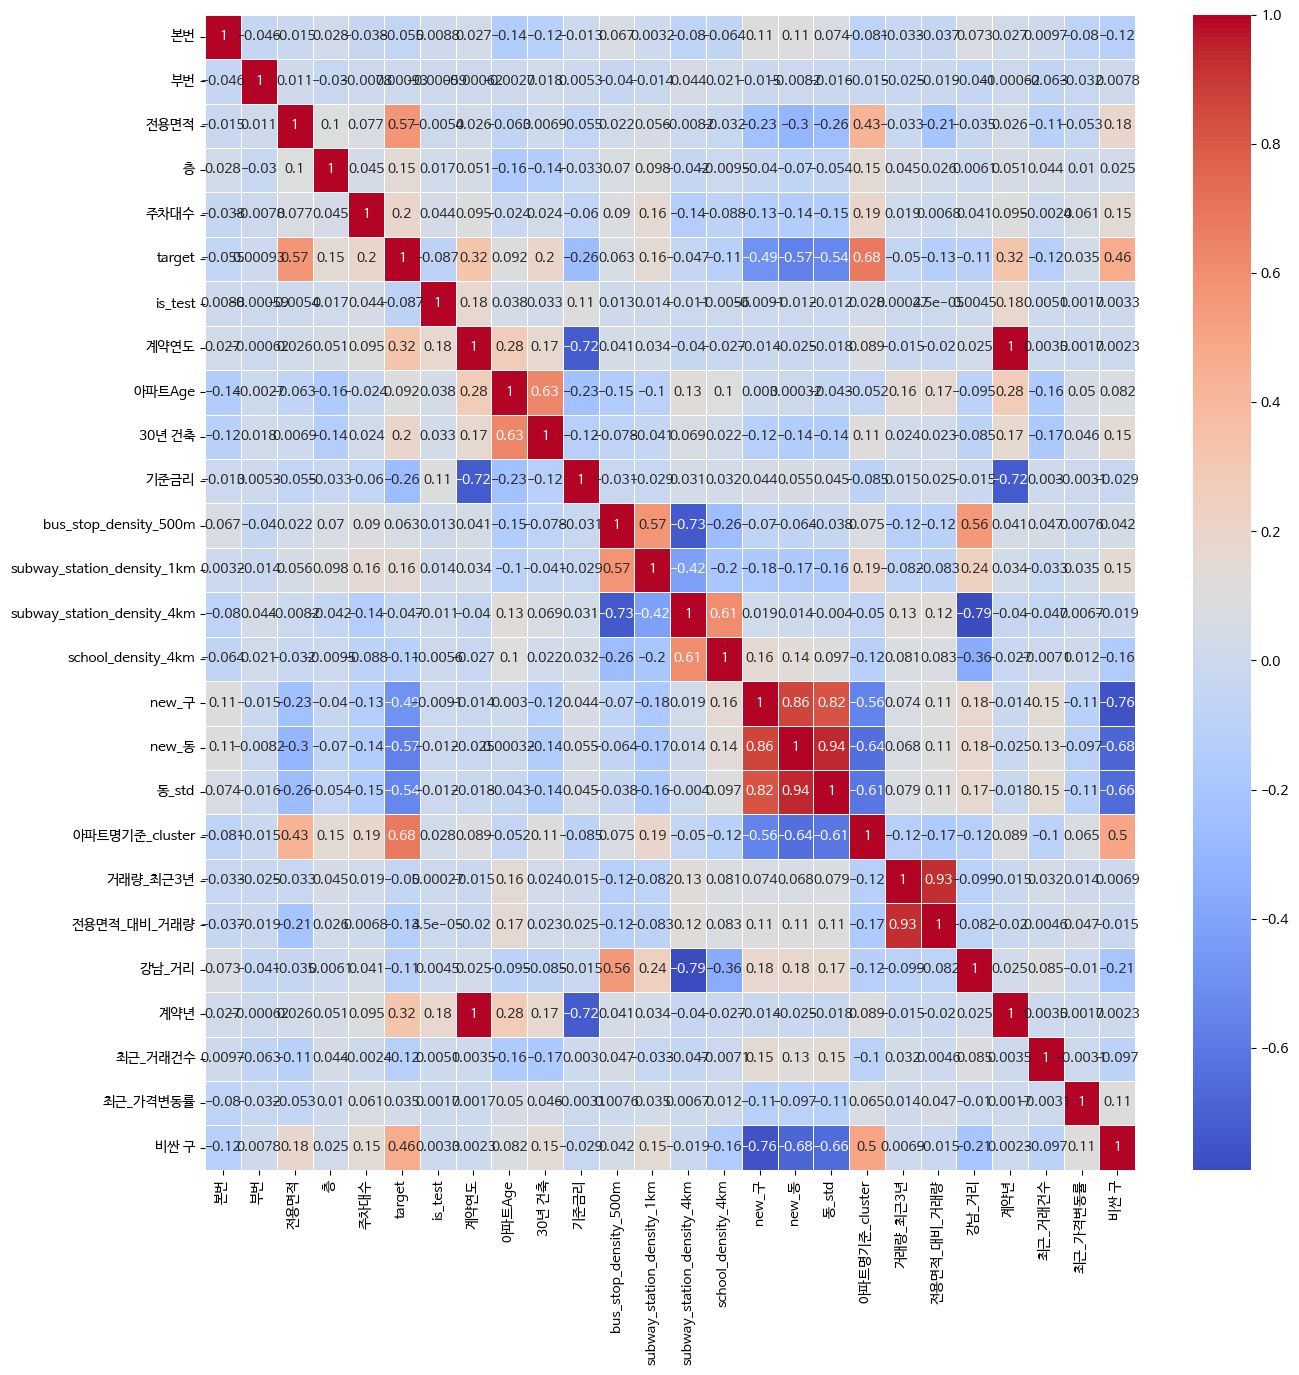

In [92]:
# 상관계수 행렬 계산
corr_matrix = concat.corr()

# 상관계수 행렬 히트맵 그리기
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# 결과 출력
plt.show()

In [93]:
# 같음
assert dt_train.shape[1] == dt_test.shape[1]

In [94]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [95]:
col_idxs = {}
for idx, col in enumerate(list(X_train.columns)):
    col_idxs[col] = idx

# 컬럼명을 인덱스로 변환
X_train2 = X_train.rename(columns=col_idxs)
X_val2 = X_val.rename(columns=col_idxs)

In [96]:
import lightgbm as lgb

# LightGBM 모델 정의
gbm = lgb.LGBMRegressor(
    n_estimators=100000,  # 최대 100,000번까지 반복
    metric="rmse"         # 평가 기준은 RMSE로 설정
)

# LightGBM 모델 학습
gbm.fit(
    X_train2, y_train,
    eval_set=[(X_train2, y_train), (X_val2, y_val)],  # 학습 및 평가 데이터 설정
    eval_metric='rmse',                             # 평가 지표로 RMSE 사용
    categorical_feature="auto",                     # 범주형 변수 자동 처리
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 50번 동안 성능이 개선되지 않으면 중단
        lgb.log_evaluation(period=10, show_stdv=True)  # 매 10번째 라운드마다 성능 출력
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4349
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 30
[LightGBM] [Info] Start training from score 58000.483999
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 23547	valid_1's rmse: 23882.5
[20]	training's rmse: 16026.6	valid_1's rmse: 16327.4
[30]	training's rmse: 13409.2	valid_1's rmse: 13691.5
[40]	training's rmse: 12202.8	valid_1's rmse: 12471.8
[50]	training's rmse: 11478.5	valid_1's rmse: 11748.7
[60]	training's rmse: 10962.8	valid_1's rmse: 11218.9
[70]	training's rmse: 10584.8	valid_1's rmse: 10842.9
[80]	training's rmse: 10233.3	valid_1's rmse: 10486.4
[90]	training's rmse: 9934.56	valid_1's rmse: 10189.3
[100]	training's rmse: 9705.62	valid_1's rmse: 9951.99
[110]	training's rmse: 9520.14	valid_1's rmse: 9767.8

[230]	training's rmse: 8139.55	valid_1's rmse: 8439.64
[240]	training's rmse: 8068.08	valid_1's rmse: 8372.8
[250]	training's rmse: 8011.88	valid_1's rmse: 8324.06
[260]	training's rmse: 7953.54	valid_1's rmse: 8268.61
[270]	training's rmse: 7883.83	valid_1's rmse: 8204.42
[280]	training's rmse: 7824.01	valid_1's rmse: 8149.03
[290]	training's rmse: 7761.52	valid_1's rmse: 8092.31
[300]	training's rmse: 7709.58	valid_1's rmse: 8048.79
[310]	training's rmse: 7660.18	valid_1's rmse: 8004.33
[320]	training's rmse: 7605.45	valid_1's rmse: 7956.04
[330]	training's rmse: 7552.39	valid_1's rmse: 7909.2
[340]	training's rmse: 7501.04	valid_1's rmse: 7862.44
[350]	training's rmse: 7452.76	valid_1's rmse: 7820.76
[360]	training's rmse: 7400.78	valid_1's rmse: 7774.15
[370]	training's rmse: 7353.46	valid_1's rmse: 7734.47
[380]	training's rmse: 7306.11	valid_1's rmse: 7692.03
[390]	training's rmse: 7267.31	valid_1's rmse: 7659.16
[400]	training's rmse: 7221.67	valid_1's rmse: 7618.09
[410]	traini

LGBMRegressor(metric='rmse', n_estimators=100000)

In [97]:
# Validation 데이터셋 예측 및 RMSE 평가
y_pred = gbm.predict(X_val2, num_iteration=gbm.best_iteration_)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE: {rmse}')

RMSE: 5273.181390961412


In [98]:
# Test 데이터 예측
y_test_pred = gbm.predict(dt_test.drop('target', axis=1).rename(columns=col_idxs), num_iteration=gbm.best_iteration_)

# 예측값을 정수형으로 변환
y_test_pred_int = y_test_pred.astype(int)

# 예측값을 데이터프레임으로 변환
preds_df = pd.DataFrame(y_test_pred_int, columns=["target"])

# 제출 파일 생성
preds_df.to_csv('LightGBM_output_Final.csv', index=False)